<a href="https://colab.research.google.com/github/RodrickGulu/Final_Year_Project/blob/main/training_model_with_blurry_image_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Error reading image: /content/drive/MyDrive/glaucoma_dataset/training/healthy/desktop.ini


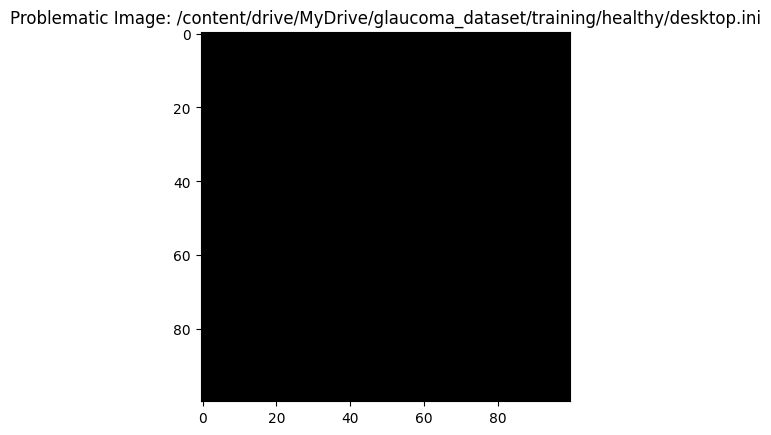

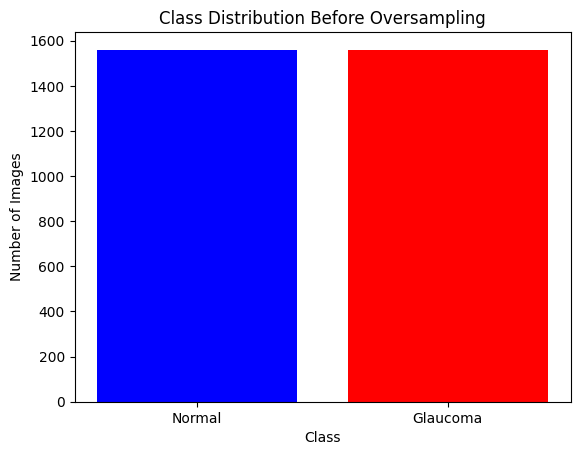

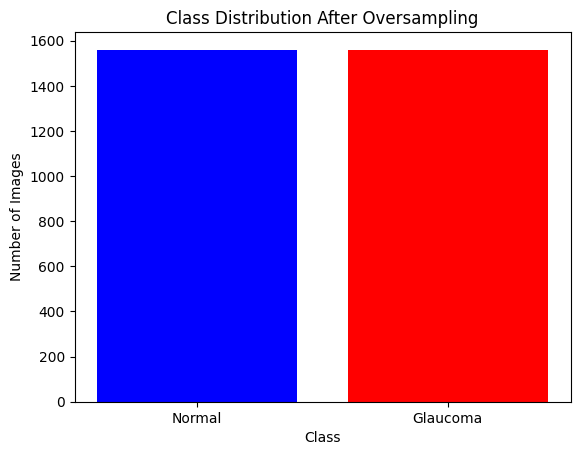

80134624/80134624 [==============================] - 2s 0us/step


Epoch 1/20
71/71 [==============================] - ETA: 0s - loss: 6.1923 - accuracy: 0.8590
Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to vgg19_glaucoma_ensemble_0.h5
71/71 [==============================] - 34s 285ms/step - loss: 6.1923 - accuracy: 0.8590 - val_loss: 0.2994 - val_accuracy: 0.8750
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - ETA: 0s - loss: 0.5595 - accuracy: 0.9626
Epoch 2: val_accuracy improved from 0.87500 to 0.89423, saving model to vgg19_glaucoma_ensemble_0.h5
71/71 [==============================] - 17s 238ms/step - loss: 0.5595 - accuracy: 0.9626 - val_loss: 0.2278 - val_accuracy: 0.8942
Epoch 3/20
71/71 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.9925
Epoch 3: val_accuracy did not improve from 0.89423
71/71 [==============================] - 17s 238ms/step - loss: 0.1816 - accuracy: 0.9925 - val_loss: 0.2628 - val_accuracy: 0.8910
Epoch 4/20
71/71 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9996
Epoch 4: val_accuracy did not improve from 0.89423
71/71 [==============================] - 16s 230ms/step - loss: 0.0608 - accuracy: 0.9996 - val_loss: 0.2710 - val_accuracy: 0.8910
Epoch 5/20
71/71 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 1.0000
Epoch 5: val_accuracy did not improv

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

def load_images_from_folder(folder_path):
    images = []
    labels = []

    for folder_name in os.listdir(folder_path):
        folder = os.path.join(folder_path, folder_name)
        if not os.path.isdir(folder):
            continue

        label = 1 if folder_name == "glaucoma" else 0

        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)

            # Check if img is not None before processing
            if img is not None:
                img = cv2.resize(img, (224, 224))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                blur = cv2.Laplacian(gray, cv2.CV_64F).var()

                # Set a threshold for blur
                if blur > 10:
                    images.append(img)
                    labels.append(label)
            else:
                print(f"Error reading image: {img_path}")
                # Plot the problematic image
                plt.imshow(np.zeros((100, 100, 3), dtype=np.uint8))  # Display a black image as a placeholder
                plt.title(f"Problematic Image: {img_path}")
                plt.show()

    return np.array(images), np.array(labels)

# Load images from the folder
dataset_path = '/content/drive/MyDrive/glaucoma_dataset/training'
images, labels = load_images_from_folder(dataset_path)

# Count the number of images in each class before oversampling
class_counts_before_oversampling = np.bincount(labels)
class_names = ["Normal", "Glaucoma"]

# Plot bar chart for class distribution before oversampling
plt.bar(class_names, class_counts_before_oversampling[1:], color=['blue', 'red'])
plt.title('Class Distribution Before Oversampling')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

# Apply oversampling using SMOTE
oversample = SMOTE(sampling_strategy='auto', random_state=42)
x_resampled, y_resampled = oversample.fit_resample(images.reshape(-1, 224 * 224 * 3), labels)

# Reshape back to image format
x_resampled = x_resampled.reshape(-1, 224, 224, 3)

# Count the number of images in each class after oversampling
class_counts_after_oversampling = np.bincount(y_resampled)
class_names = ["Normal", "Glaucoma"]

# Plot bar chart for class distribution after oversampling
plt.bar(class_names, class_counts_after_oversampling[1:], color=['blue', 'red'])
plt.title('Class Distribution After Oversampling')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

# Split the resampled data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.1)

# Model architecture
def create_model():
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    for layer in vgg.layers:
        layer.trainable = False

    model = Sequential()
    model.add(vgg)
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Create an ensemble of three models
num_models = 3
models = [create_model() for _ in range(num_models)]

class_weights = {0: 5, 1: 7}

# Model callbacks for each model
callbacks_list = [ModelCheckpoint(f"vgg19_glaucoma_ensemble_{i}.h5", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False, period=1) for i in range(num_models)]

# Training each model in the ensemble
histories = []
for i in range(num_models):
    history = models[i].fit(x_train, y_train, batch_size=40, epochs=20, validation_data=(x_test, y_test), verbose=1, callbacks=[callbacks_list[i], EarlyStopping(monitor="val_accuracy", patience=10, verbose=1)], class_weight=class_weights)
    histories.append(history)

# Combine predictions from all models using voting
ensemble_predictions = np.mean([model.predict(x_test) for model in models], axis=0)
ensemble_predictions_binary = (ensemble_predictions > 0.5).astype(int)

# Evaluate the ensemble
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions_binary)
print("Ensemble Accuracy Score:", ensemble_accuracy)


Classification Report for Ensemble Predictions:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       153
           1       0.95      0.92      0.93       159

    accuracy                           0.93       312
   macro avg       0.93      0.93      0.93       312
weighted avg       0.93      0.93      0.93       312

Confusion Matrix for Ensemble Predictions:
[[145   8]
 [ 13 146]]


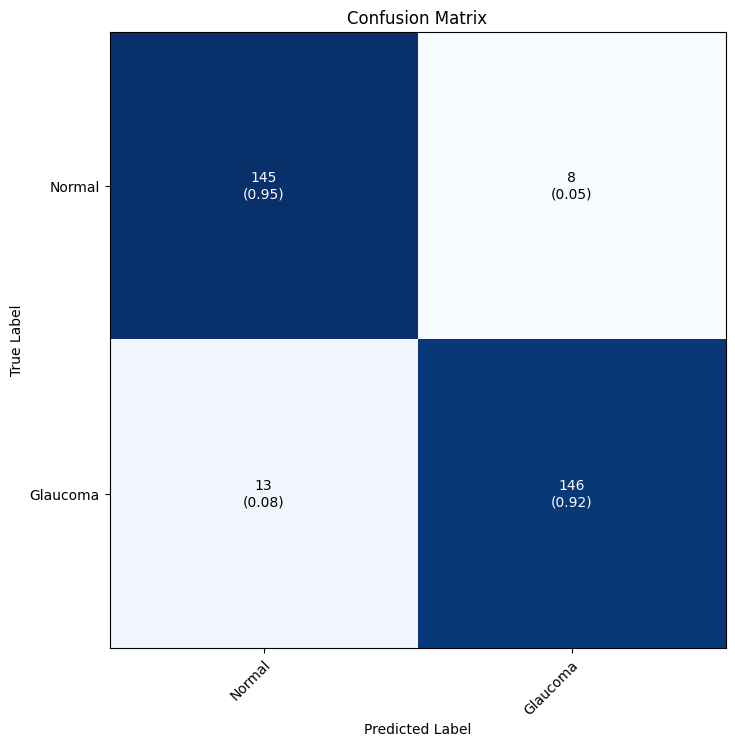

In [3]:
# Compute the confusion matrix
# Evaluating the model
ensemble_classification_report = classification_report(y_test, ensemble_predictions_binary)
print("Classification Report for Ensemble Predictions:")
print(ensemble_classification_report)

cm = confusion_matrix(y_test, ensemble_predictions_binary)
print("Confusion Matrix for Ensemble Predictions:")
print(cm)

# Plot the confusion matrix
plot_confusion_matrix(conf_mat=cm, figsize=(8, 8), class_names=["Normal", "Glaucoma"], show_normed=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

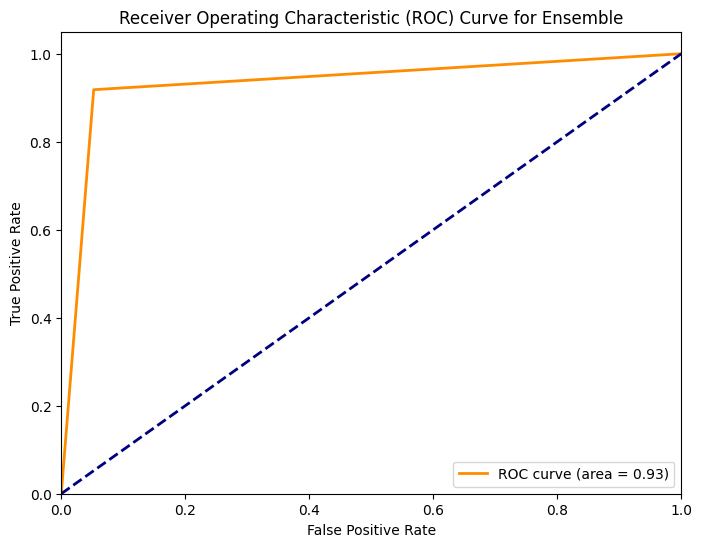

In [4]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, ensemble_predictions_binary)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Ensemble')
plt.legend(loc='lower right')
plt.show()
